# Metabolic Index trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy import stats as scistats
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt


import constants
import metabolic as mi
import util

## Load traits database

In [3]:
df = mi.open_traits_df()
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


## Trait distributions

Fit normal distribution to $E_o$ and lognormal distribution to $A_o$ ($A_c$).

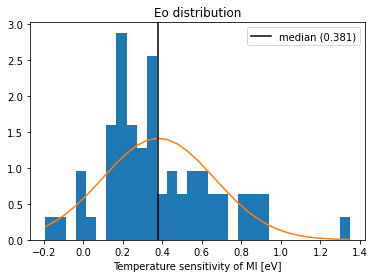

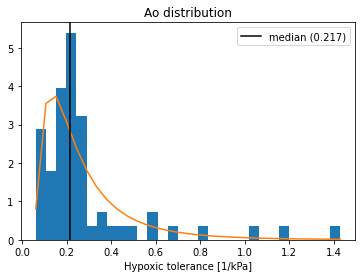

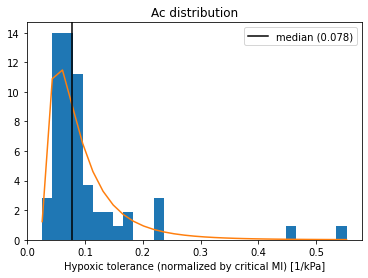

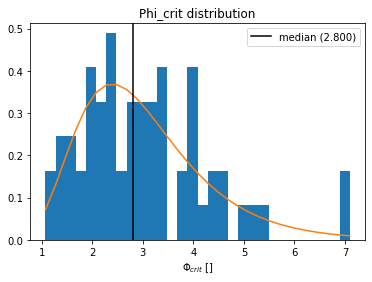

In [4]:
def plot_trait_hist(trait):
    fig, ax = plt.subplots()
    
    pdf = mi.trait_pdf(df, trait)
    beta = pdf.beta
    trait_median = pdf.median()    

    trait_values = df[trait].values    
    if pdf.dist_type == 'lognormal':
        log10_values = np.log10(trait_values)
        n, bins, h = ax.hist(trait_values, np.logspace(log10_values.min(), log10_values.max(), 30), 
                             density=True);
    else:
        n, bins, h = ax.hist(trait_values, 30, density=True);
    
    pdf_fitted = pdf.fitted(bins)

    ax.plot(bins, pdf_fitted)
    ax.set_title(f'{trait} distribution')
    ax.set_xlabel(util.attrs_label(df[trait].attrs));

    ax.axvline(trait_median, color='black', label=f'median ({trait_median:0.3f})')

    ax.legend();
    return trait_median, beta
    
Eo_med, Eo_beta = plot_trait_hist('Eo')
Ao_med, Ao_beta = plot_trait_hist('Ao')
Ac_med, Ac_beta = plot_trait_hist('Ac')
Phi_crit_med, Phi_crit_beta = plot_trait_hist('Phi_crit')

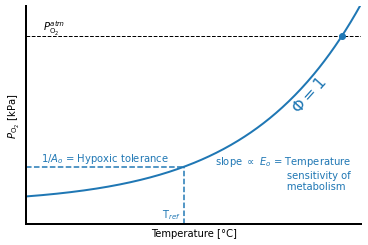

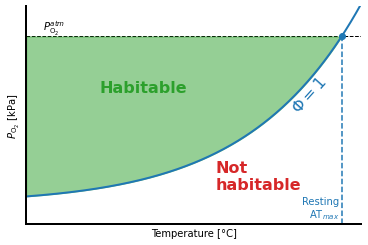

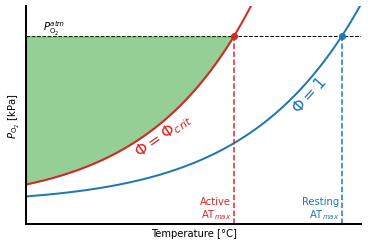

In [5]:
PO2_atm = constants.XiO2 * constants.kPa_per_atm
T = np.arange(0, 32, 0.1)

def make_figure(which):
    fig, ax = plt.subplots()

    
    pO2_at_Phi_crit = mi.pO2_at_Phi_one(T, Ac_med, Eo_med*2)
    pO2_at_Phi_one = mi.pO2_at_Phi_one(T, Ao_med, Eo_med*2)

    ATmax_crit = mi.compute_ATmax(PO2_atm, Ac_med, Eo_med*2)
    ATmax_one = mi.compute_ATmax(PO2_atm, Ao_med, Eo_med*2)


    color_rest = 'tab:blue'
    color_active = 'tab:red'

    # active
    if 'active' in which:
        ax.plot(T, pO2_at_Phi_crit, '-', linewidth=2, color=color_active)
        ax.fill_between(
            T, pO2_at_Phi_crit, constants.XiO2 * constants.kPa_per_atm, 
            where=pO2_at_Phi_crit<=PO2_atm, 
            color='tab:green',
            alpha=0.5,    
        )
        ax.plot(ATmax_crit, PO2_atm, 'o', color=color_active,)
        ax.text(10, mi.pO2_at_Phi_one(10, Ac_med, Eo_med*2)-1.5, '$\Phi = \Phi_{crit}$', 
                color=color_active,
                fontsize=16,
                rotation=35)
        
        
    # resting
    ax.plot(T, pO2_at_Phi_one, '-', linewidth=2, color=color_rest)
    ax.plot(ATmax_one, PO2_atm, 'o', color=color_rest,)
    ax.text(25, mi.pO2_at_Phi_one(25, Ao_med, Eo_med*2)-1.5, '$\Phi = 1$', 
            color=color_rest,
            fontsize=16,
            rotation=48)    
    
    if 'resting' in which:
        ax.fill_between(
            T, pO2_at_Phi_one, constants.XiO2 * constants.kPa_per_atm, 
            where=pO2_at_Phi_one<=PO2_atm, 
            color='tab:green',
            alpha=0.5,    
        )


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)    
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.set_xlim([T.min(), T.max()])
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel('$P_{\mathrm{O}_2}$ [kPa]')

    xlm = ax.get_xlim()
    ylm = (-2.6251270379913803, 73.89798889088694) #ax.get_ylim()

    ax.set_ylim([ylm[0], PO2_atm + 0.05*np.diff(ylm)])

    ax.axhline(PO2_atm, linewidth=1, color='k', linestyle='--', zorder=-100)
    ax.text(xlm[0]+0.05*np.diff(xlm), PO2_atm + 0.01*np.diff(ylm), '$P_{\mathrm{O}_2}^{atm}$')
    
    if 'base' in which:
        ax.plot([15., 15.], [ylm[0], mi.pO2_at_Phi_one(15, Ao_med, Eo_med*2)], '--', color=color_rest)
        ax.plot([xlm[0], 15.], [mi.pO2_at_Phi_one(15, Ao_med, Eo_med*2), mi.pO2_at_Phi_one(15, Ao_med, Eo_med*2)], '--', color=color_rest)            
        ax.text(15-0.25, ylm[0]+0.01*np.diff(ylm), 
                'T$_{ref}$', 
                ha='right', 
                color=color_rest)
        
        ax.text(15/2, mi.pO2_at_Phi_one(15, Ao_med, Eo_med*2)+0.01*np.diff(ylm), 
                '$1/A_o$ = Hypoxic tolerance', 
                ha='center', 
                color=color_rest)  
        
        spc = ' ' * 23
        ax.text(18, mi.pO2_at_Phi_one(18, Ao_med, Eo_med*2)-0.06*np.diff(ylm), 
                f'slope $\propto$ $E_o$ = Temperature\n{spc}sensitivity of\n{spc}metabolism', 
                ha='left', 
                color=color_rest) 
    
    if 'resting' in which:
        ax.text(7, PO2_atm/1.5, 'Habitable', color='tab:green', fontsize=16, fontweight='bold')
        ax.text(18, PO2_atm/12, 'Not\nhabitable', color='tab:red', fontsize=16, fontweight='bold')        
        
    if 'resting' in which or 'active' in which:
        ax.plot([ATmax_one, ATmax_one], [ylm[0], PO2_atm], '--', color=color_rest)    
        ax.text(ATmax_one-0.25, ylm[0]+0.01*np.diff(ylm), 
                'Resting\nAT$_{max}$', 
                ha='right', 
                color=color_rest)
    
    if 'active' in which:    
        ax.plot([ATmax_crit, ATmax_crit], [ylm[0], PO2_atm], '--', color=color_active)        
        ax.text(ATmax_crit-0.25, ylm[0]+0.01*np.diff(ylm), 
                'Active\nAT$_{max}$', 
                ha='right', 
                color=color_active)

        
    plt.savefig(f'figures/misc/phi-explain-{which}.png', dpi=300)

make_figure('base')    
make_figure('resting')
make_figure('active')

In [6]:
Phyla = list(df.Phylum.unique())
Phyla

['Crustacea', 'Chordata', 'Mollusca', 'Cnidaria', 'Tunicata']

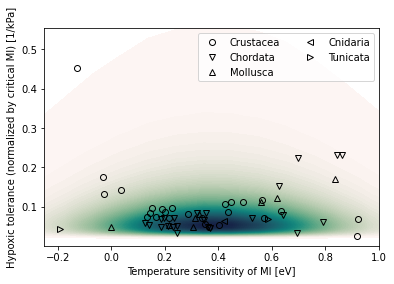

In [7]:
import cmocean
markerorder = ["o", "v", "^", "<", ">", "s", "p", "P"]

Eo_bins = np.linspace(-1., 2., 30)
Ac_bins = np.logspace(-3, np.log10(df.Ac.max()), 50)

X, Y = np.meshgrid(Eo_bins, Ac_bins)
Z1, Z2 = np.meshgrid(scistats.norm.pdf(Eo_bins, *Eo_beta), 
                     scistats.lognorm.pdf(Ac_bins, *Ac_beta)
                    )

fig, ax = plt.subplots() #figsize=(6, 6))

mx = np.max(Z1*Z2)
cf = ax.contourf(X, Y, Z1*Z2 / mx, 
            cmap=cmocean.cm.tempo, 
            levels=np.arange(0.001, 1.02, 0.01),
           )
#plt.colorbar(cf)

for i, phylum in enumerate(Phyla):
    ndx = df.Phylum == phylum
    ax.plot(df.Eo.loc[ndx], df.Ac.loc[ndx], 
            linestyle='none', 
            marker=markerorder[i], 
            color='k',
            markerfacecolor='none',
            label=phylum,
           )

ax.set_xlabel(util.attrs_label(df.Eo.attrs));
ax.set_ylabel(util.attrs_label(df.Ac.attrs));

ax.set_xlim((-0.25, 1));
#ax.set_ylim((0, 0.4));

ax.legend(ncol=2);
plt.savefig(f'figures/misc/trait-space-idealized.png', dpi=300)